1.Load Dataset

In [ ]:
import pandas as pd

# load dataset
df = pd.read_csv("Hospital_OPD_Queue_Dataset.csv")

# convert arrival_time to datetime
df['arrival_time_dt'] = pd.to_datetime(df['arrival_time'], format='%I:%M %p')

# preview
print("First 5 rows:")
print(df.head())


First 5 rows:
   patient_id patient_type arrival_time  waiting_time  service_time  \
0           1       normal      7:01 AM           0.0          9.96   
1           2        staff      7:03 AM           0.0          8.46   
2           3   lab_report      7:09 AM           0.0          6.59   
3           4   lab_report      7:09 AM           0.0          4.57   
4           5       normal      7:10 AM           0.0         17.60   

  assign_doctor     arrival_time_dt  
0          Dr_1 1900-01-01 07:01:00  
1          Dr_2 1900-01-01 07:03:00  
2          Dr_3 1900-01-01 07:09:00  
3          Dr_4 1900-01-01 07:09:00  
4          Dr_5 1900-01-01 07:10:00  


2.Calculate Current Doctor Utilization

In [ ]:
# total session duration in minutes
session_start = df['arrival_time_dt'].min()
session_end = df['arrival_time_dt'].max()
session_minutes = (session_end - session_start).total_seconds() / 60

# current doctor busy time
doctor_busy_time = df.groupby('assign_doctor')['service_time'].sum()
doctor_utilization = (doctor_busy_time / session_minutes) * 100

print("Current Doctor Utilization (%):")
print(doctor_utilization)


Current Doctor Utilization (%):
assign_doctor
Dr_1    146.037037
Dr_2    143.946128
Dr_3    142.124579
Dr_4    137.242424
Dr_5    131.343434
Name: service_time, dtype: float64


3.Dynamic Redistribution of Patients

In [ ]:
# copy dataframe for redistribution
df_redistributed = df.copy()

# list of doctors
doctors = df['assign_doctor'].unique()

# track total assigned service time per doctor
doctor_time = {doc: 0 for doc in doctors}

# reassign patients in order of arrival
for idx, row in df_redistributed.iterrows():
    # choose doctor with least total assigned time so far
    doctor_min = min(doctor_time, key=doctor_time.get)
    df_redistributed.at[idx, 'assign_doctor'] = doctor_min
    # update the assigned time
    doctor_time[doctor_min] += row['service_time']

# recalculate doctor utilization
doctor_busy_time_new = df_redistributed.groupby('assign_doctor')['service_time'].sum()
doctor_utilization_new = (doctor_busy_time_new / session_minutes) * 100

print("Doctor Utilization After Redistribution (%):")
print(doctor_utilization_new)


Doctor Utilization After Redistribution (%):
assign_doctor
Dr_1    139.579125
Dr_2    142.646465
Dr_3    141.178451
Dr_4    137.936027
Dr_5    139.353535
Name: service_time, dtype: float64


4.Compare Waiting Time

In [ ]:
# compare average utilization before and after
utilization_df = pd.DataFrame({
    'Before': doctor_utilization,
    'After': doctor_utilization_new
})

print(utilization_df)


                   Before       After
assign_doctor                        
Dr_1           146.037037  139.579125
Dr_2           143.946128  142.646465
Dr_3           142.124579  141.178451
Dr_4           137.242424  137.936027
Dr_5           131.343434  139.353535


Visualization

<Figure size 2000x600 with 0 Axes>

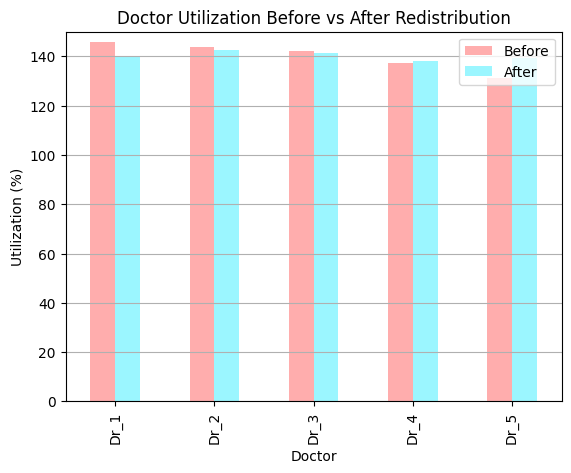

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,6))
utilization_df.plot(kind='bar', color=['#FFADAD', '#9BF6FF'])
plt.title("Doctor Utilization Before vs After Redistribution")
plt.ylabel("Utilization (%)")
plt.xlabel("Doctor")
plt.ylim(0, 150)
plt.grid(axis='y')
plt.show()
